In [ ]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 2.1 MB/s 
     |████████████████████████████████| 100 kB 5.7 MB/s 


In [ ]:
#Plotting libraries:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch


import pandas as pd
import numpy as np

#sklearn library:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from datetime import datetime
import os, sys
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib


# TensorFlow, Keras, PyTorch and DeepXDE
import tensorflow as tf
from tensorflow import keras
import torch
import deepxde as dde


#gemerate array from csv:
from numpy import genfromtxt

#randomly select images from a direcetory:
import os, random

#Import tqdm for progress bar
from tqdm import tqdm

#for unormalising:
import math
from sklearn.preprocessing import MinMaxScaler


from PIL import Image
from numpy import asarray

import cv2

import time

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1

Instructions for updating:
non-resource variables are not supported in the long term


Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [ ]:
t0 = time.time()

def pde(X, u):
  '''Form the PDE and return the loss function from the PDE

  X: x, y and t matrix

  '''
  du_X = tf.gradients(u, X)[0]
  du_x, du_y, du_t = du_X[:, 0:1], du_X[:, 1:2], du_X[:, 2:3] # first derivatives of x, y, t

  du_xx = tf.gradients(du_x, X)[0][:, 0:1] #double derivative of x
  du_yy = tf.gradients(du_y, X)[0][:, 1:2] #double derivative of y

  return ( du_t - 0.5*(du_xx + du_yy) )



def func(X):
  ''' The inital shape of the heat distribution.
  The plots shown below are contours.
  (x and y is the shape shown, t is change with each time step , and u is the color bar )

  X[:, 0:1] = x
  X[:, 1:2] = y
  X[:, 2:3] = t
  '''
  return (X[:, 0:1]  - 3)  + 0*X[:, 1:2] + X[:, 2:3] #u equation (at t=0 --> initial condition)



geom = dde.geometry.geometry_2d.Rectangle([0,0], [3,1]) #shape of plot/distribution (0,0 = bottom left coord & 3,1 = top right coord )
timedomain = dde.geometry.TimeDomain(0, 1) #time range
geomtime = dde.geometry.GeometryXTime(geom, timedomain) # time + space domain

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary) #form boundary condition in appropriate format
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial) #form initial condition in appropriate format

print(bc )
print(ic)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=8000,
    num_boundary=2000,
    num_initial=3000,
    solution=func,
    num_test=1000,

) #format/prepare data


#nn layers (1 layer of 3 inp neurons, 4 layers of 32 neurons, 1 layer of 1 output neuron which is u):
layer_size = [3] + [32]*4 + [1]
activation = "tanh"
initializer = "Glorot uniform"


net = dde.maps.FNN(layer_size, activation, initializer) # finish constructing the nn
model = dde.Model(data, net) #make model
model.compile("adam", lr=0.001)


t1 = time.time()

losshistory, train_size = model.train(epochs=50000) #train for 50K epochs

t2 = time.time()
print("training time")
print(t2-t1)


#dde.postprocessing.plot_loss_history(losshistory)

#plt.show()
#plt.savefig(save_folder + 'loss_history')
#plt.close()






Compiling model...
Building feed-forward neural network...
'build' took 0.086821 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.098733 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.43e-02, 2.51e+00, 3.45e+00]    [2.61e-02, 2.51e+00, 3.45e+00]    []  
1000      [7.71e-04, 2.58e-03, 2.03e-03]    [4.57e-04, 2.58e-03, 2.03e-03]    []  
2000      [2.93e-04, 1.93e-03, 1.34e-03]    [2.44e-04, 1.93e-03, 1.34e-03]    []  
3000      [2.13e-04, 1.60e-03, 1.15e-03]    [1.70e-04, 1.60e-03, 1.15e-03]    []  
4000      [1.83e-04, 1.24e-03, 9.83e-04]    [1.27e-04, 1.24e-03, 9.83e-04]    []  
5000      [1.73e-04, 9.19e-04, 6.82e-04]    [8.34e-05, 9.19e-04, 6.82e-04]    []  
6000      [1.26e-04, 7.03e-04, 3.42e-04]    [6.56e-05, 7.03e-04, 3.42e-04]    []  
7000      [9.89e-05, 5.94e-04, 1.86e-04]    [6.84e-05, 5.94e-04, 1.86e-04]    []  
8000      [8.54e-05, 5.01e-04, 1.21e-04]    [5.75e-05, 5.01e-04, 1.21e-04]    []  
9000      [7.19e-05, 4.26e-04, 6.75e-05]    [4.42e-05, 4.26e-04, 6.75e-05]    []  
10000   

In [ ]:
def plot(geom_time,resolution,data,save_directory,name):  #output_data = pred[:,j]
    img_save_directory = save_directory + 'visualize_result'
    if not os.path.exists(img_save_directory):
        os.makedirs(img_save_directory)
    img_save_directory = img_save_directory + '/'
    fig = plt.figure()
    ims_test = []
    if name[-10:] =='prediction':
        t_max = 1
        t_min = -1

    else:
        t_max = np.max(data)
        t_min = np.min(data)
    nx, ny,nt = resolution
    data = data.reshape((len(data),))
    for t in range(nt):
        plt.scatter(geom_time[:,0][nx*ny*t:nx*ny*(t+1)],geom_time[:,1][nx*ny*t:nx*ny*(t+1)],
            c=data[nx*ny*t:nx*ny*(t+1)].reshape((len(data[nx*ny*t:nx*ny*(t+1)]),)), cmap='jet',vmin=t_min, vmax=t_max, s= 200, marker = 's')
        plt.colorbar()
        plt.xlabel('x domain')
        plt.ylabel('y domain')
        plt.title( 't = ' + "{:.3f}".format(geom_time[:,2][nx*ny*t +1 ]))
        plt.show()
        filename = name + '_' +str(t)
        plt.savefig(os.path.join(img_save_directory, filename + '.png'))
        plt.close()
        im = Image.open(os.path.join(img_save_directory, filename + '.png'))
        ims_test.append(im)
    ims_test[0].save(os.path.join(img_save_directory + name + '.gif'),save_all = True,
            append_images = ims_test[1:], optimize = False, duration = 60, loop = 1000)
    im.show()


def plot_mean_data_history(duration, resolution, data,title,save_directory):
    nx,ny,nt = resolution
    m = []
    for t in range(nt):
        mean_t = np.mean(abs(data[nx*ny*t:nx*ny*(t+1)]))
        m.append(mean_t)

    time = np.array(range(nt))*(duration/nt)
    time = time.reshape((nt,1))
    plt.plot(time, np.asarray(m))
    plt.title(title)
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    plt.savefig(os.path.join(save_directory, 'mean_' + title + '_history.png'))

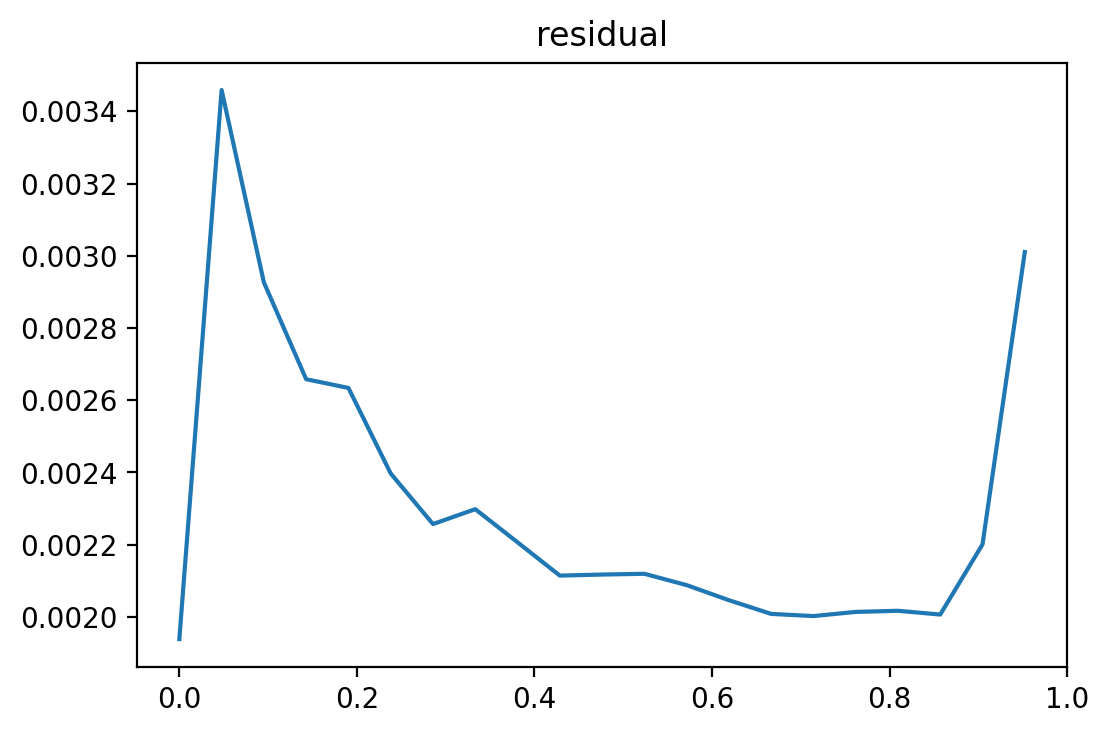

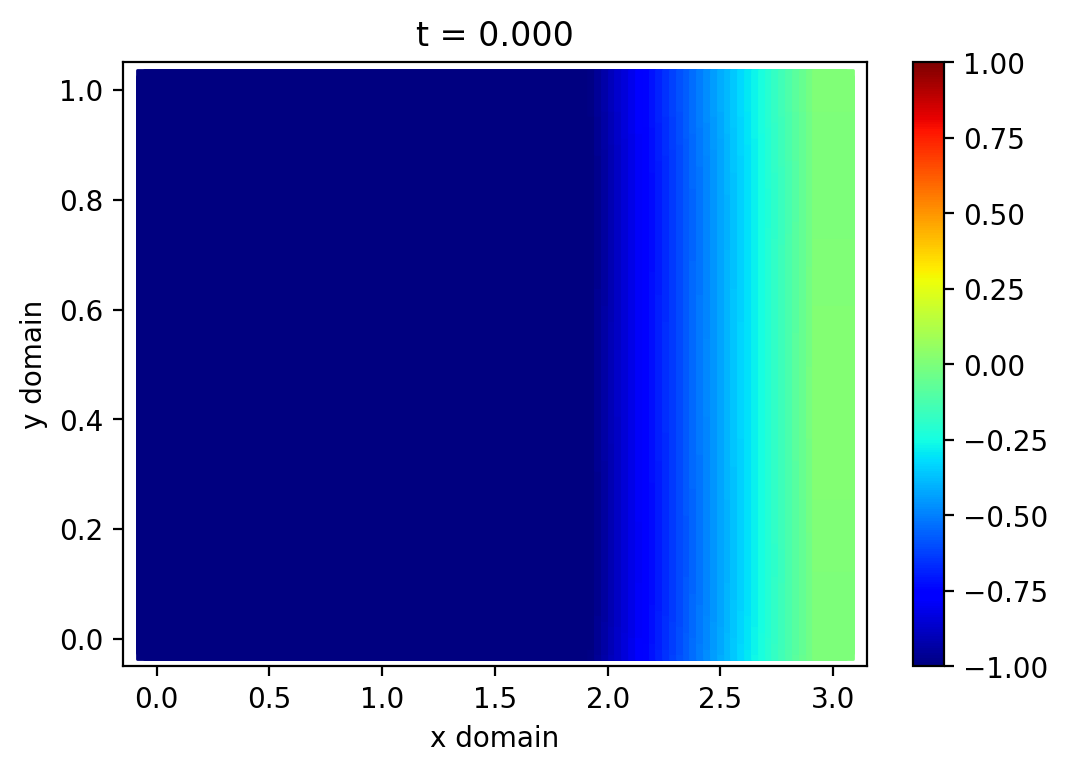

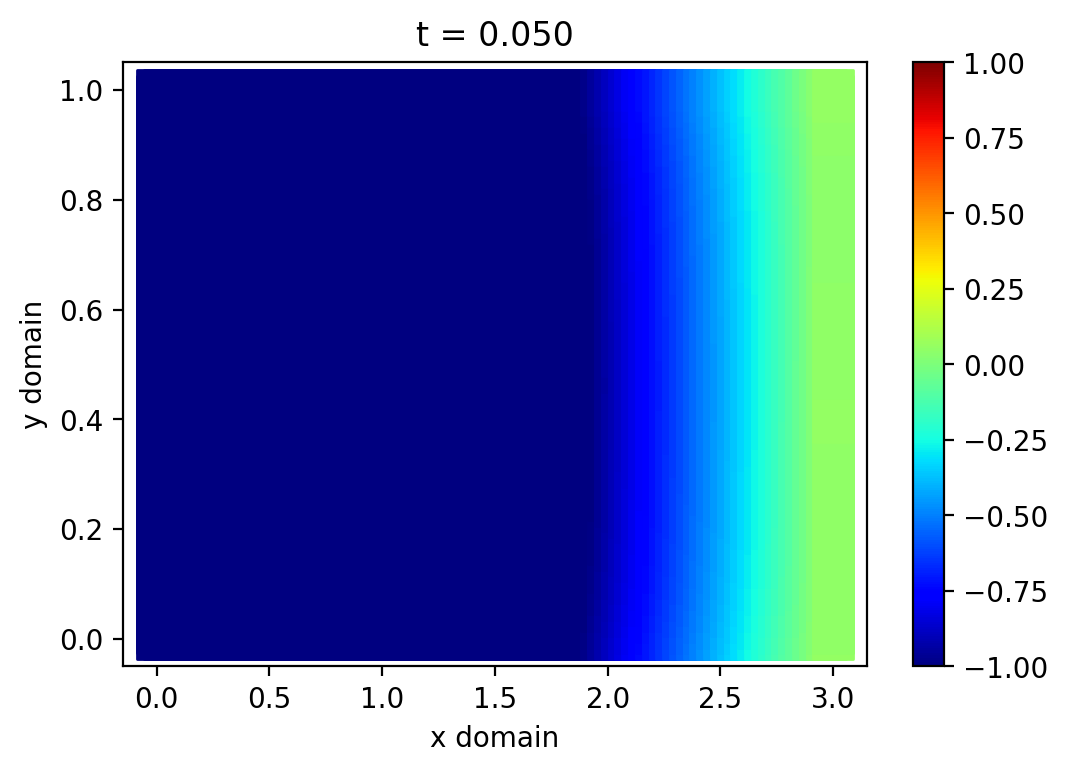

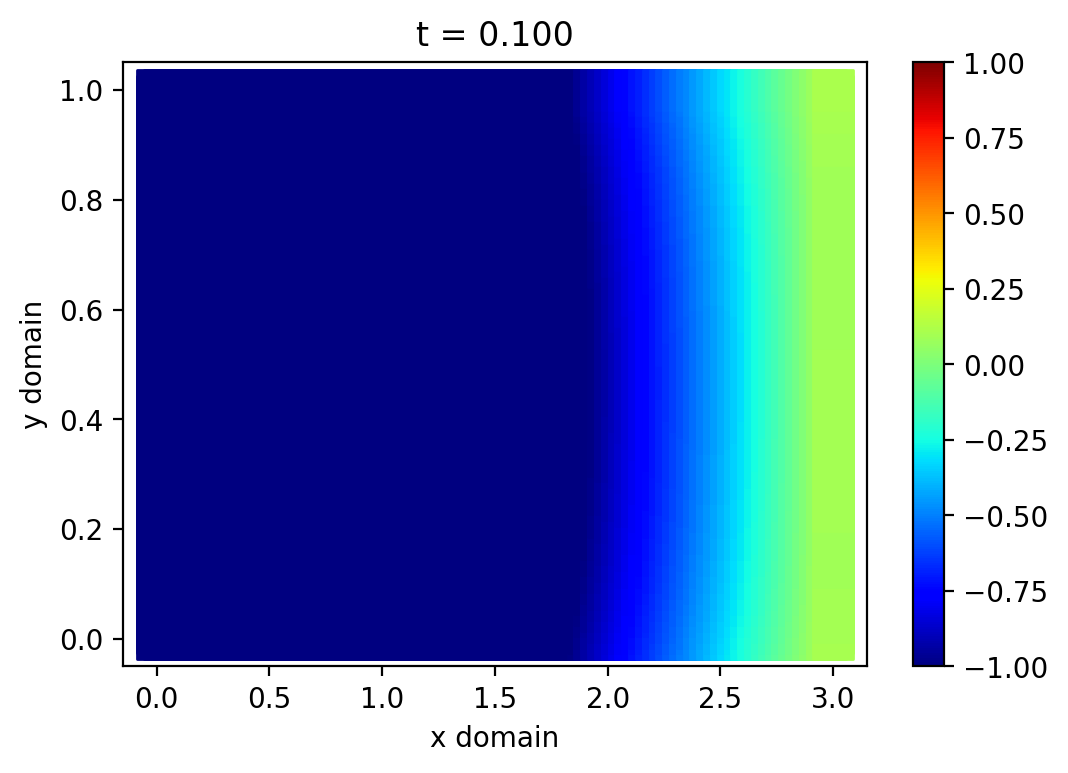

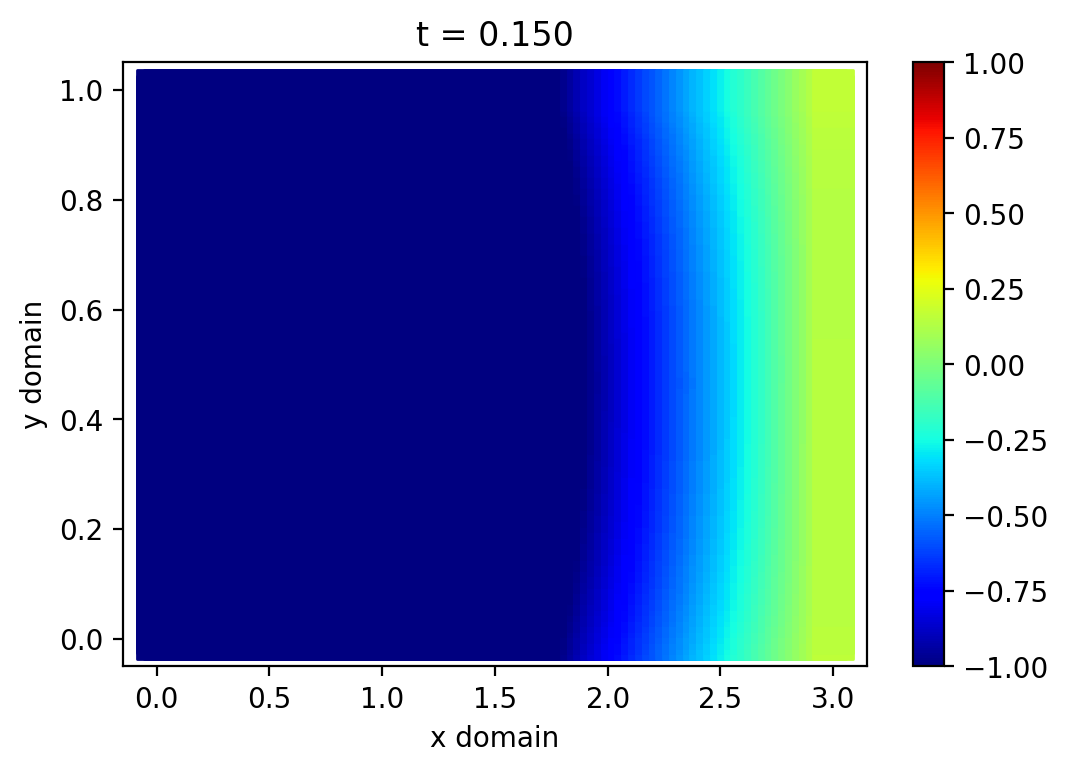

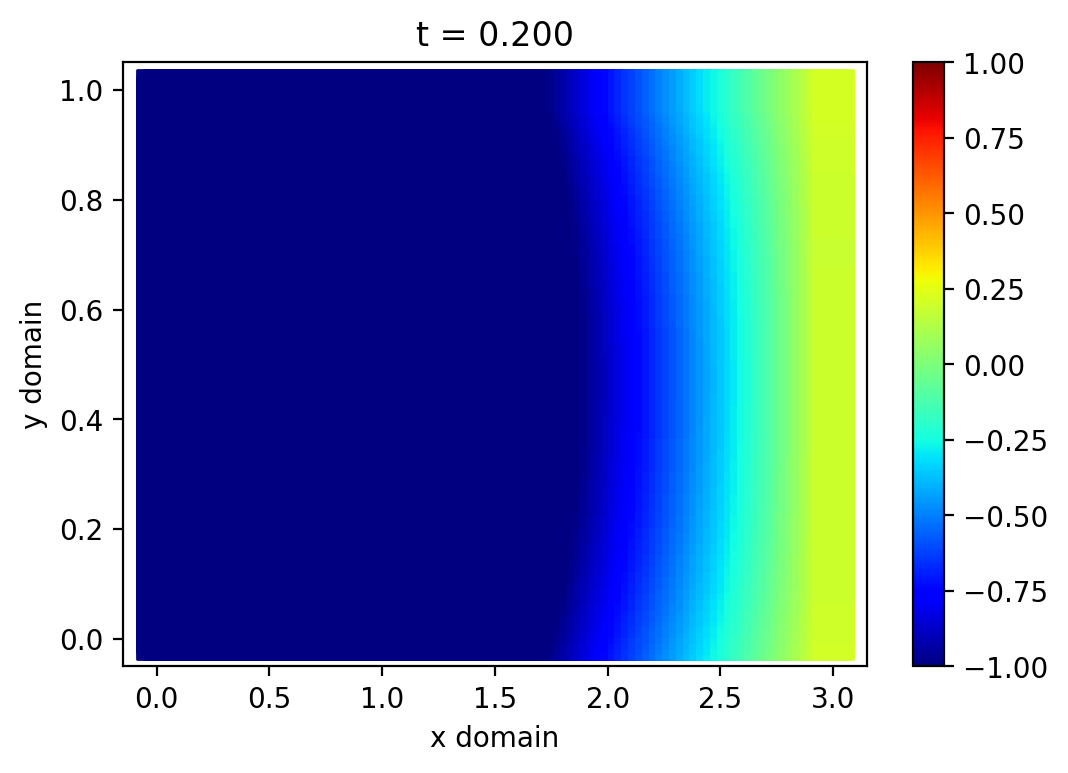

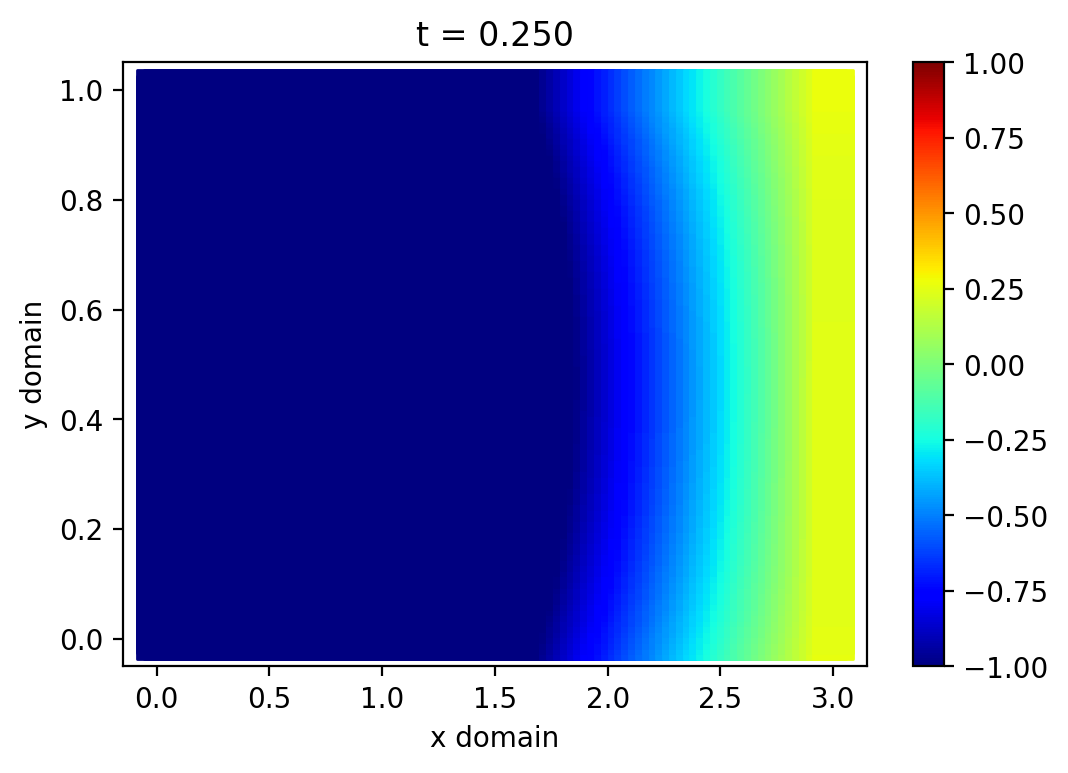

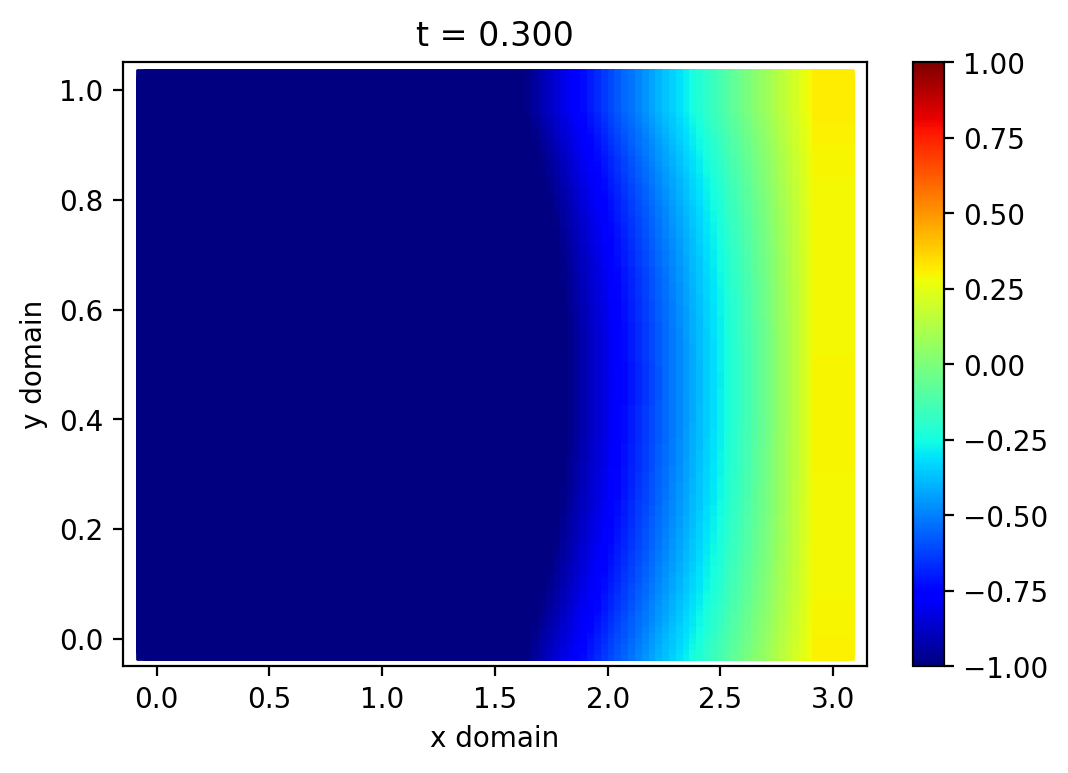

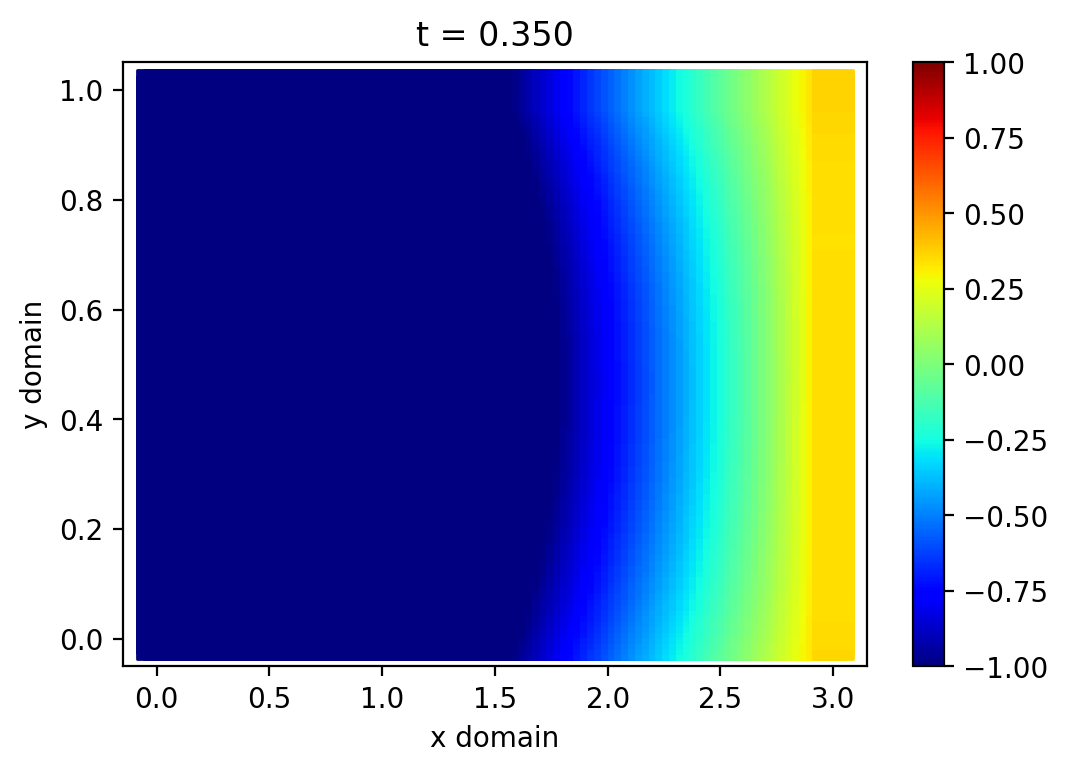

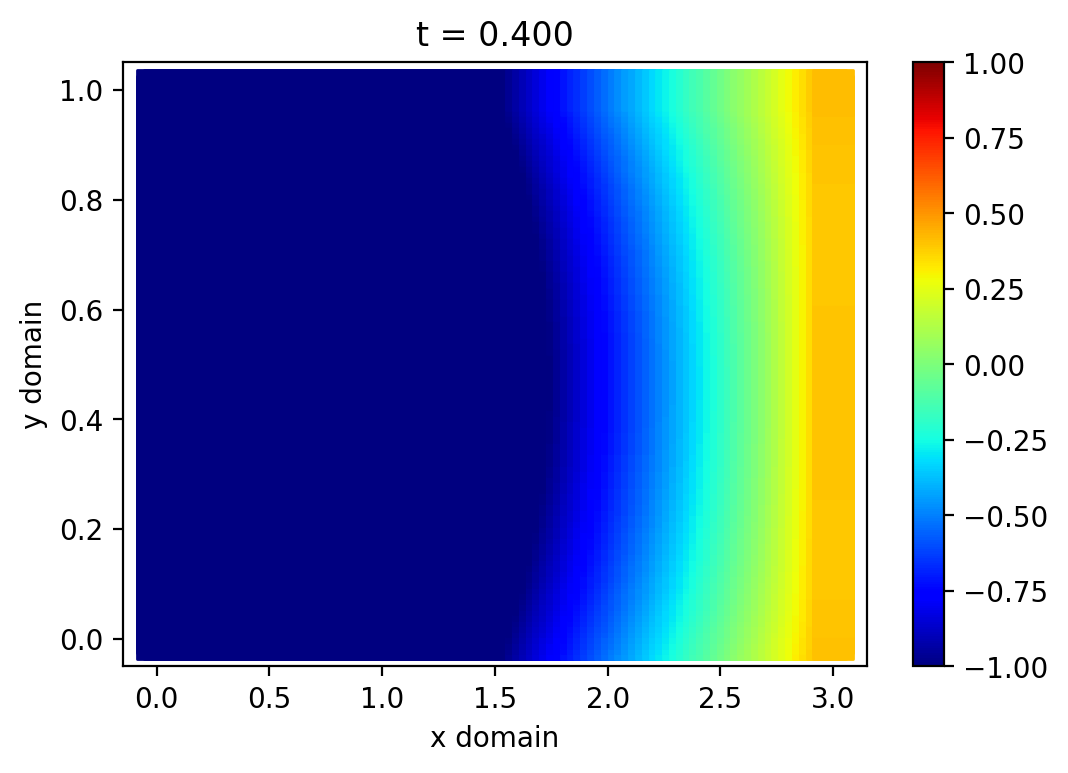

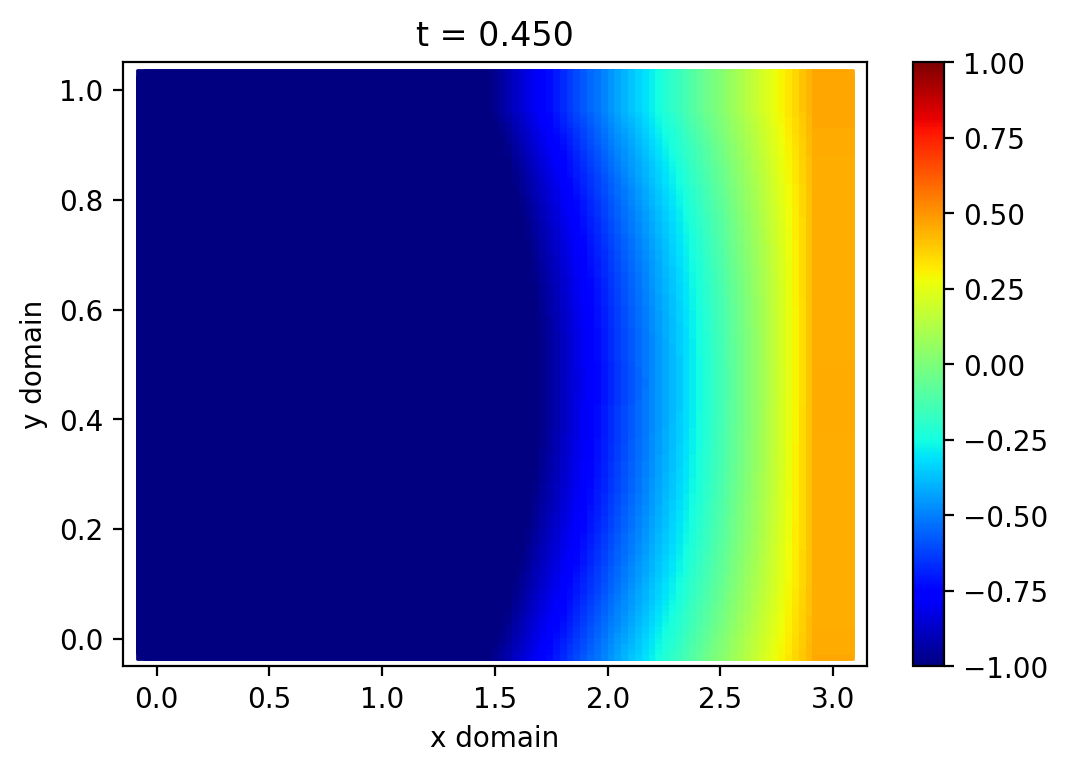

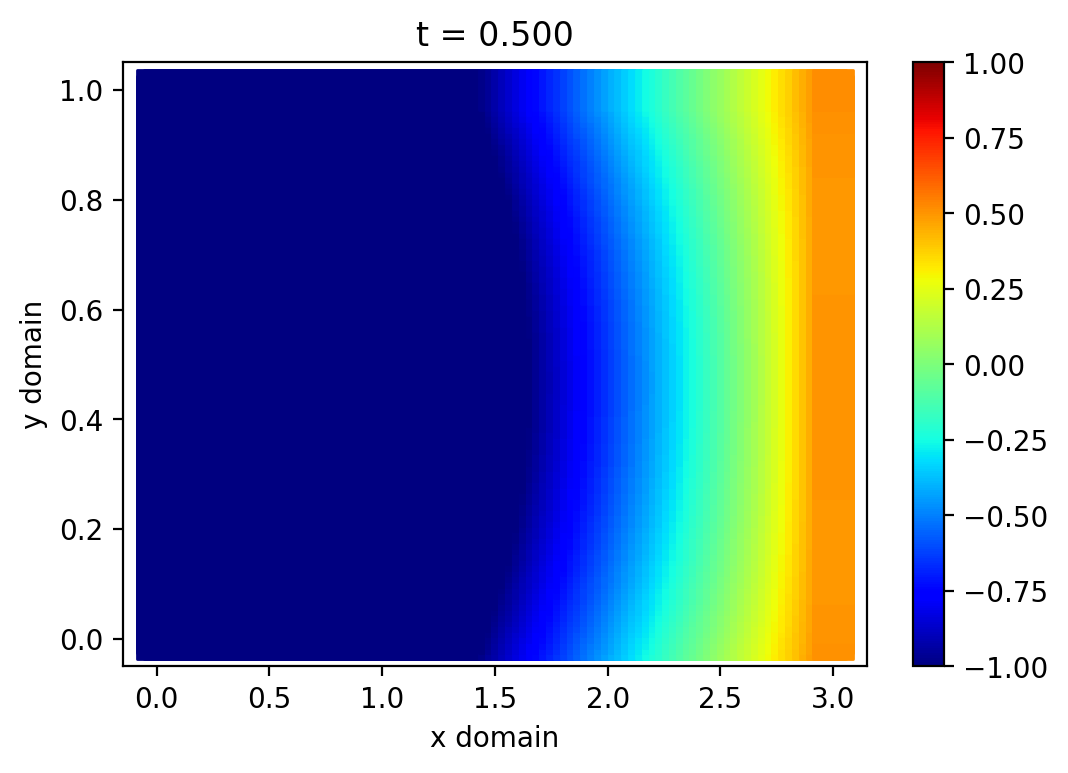

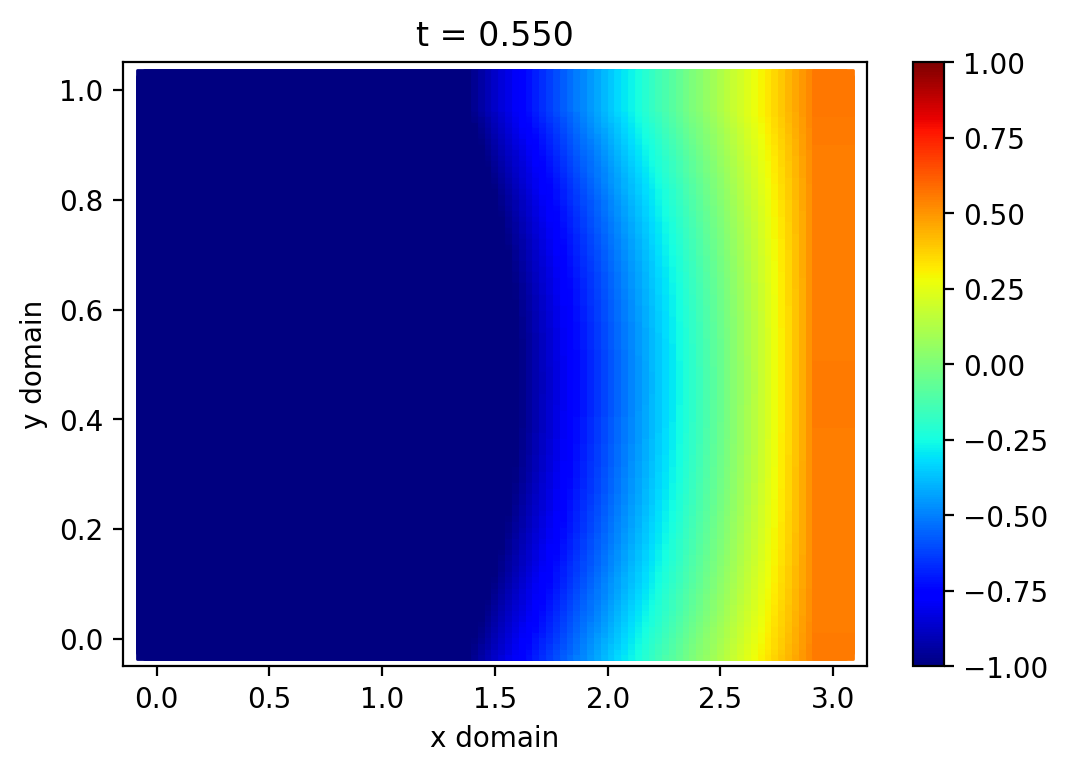

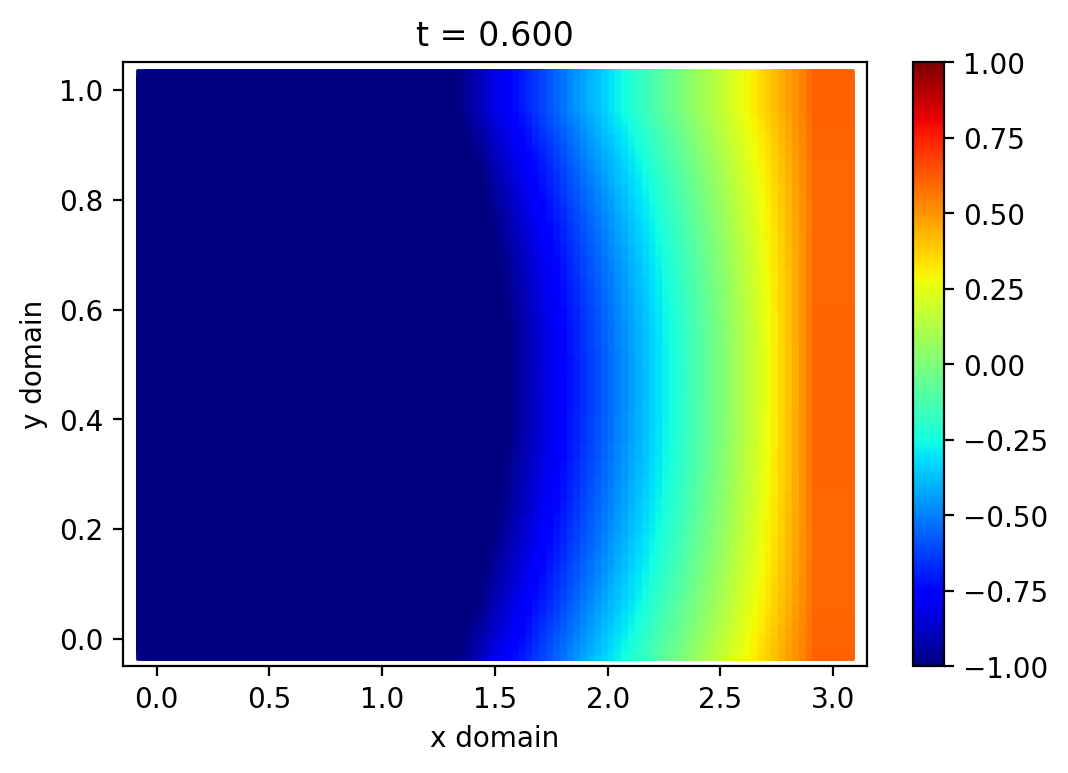

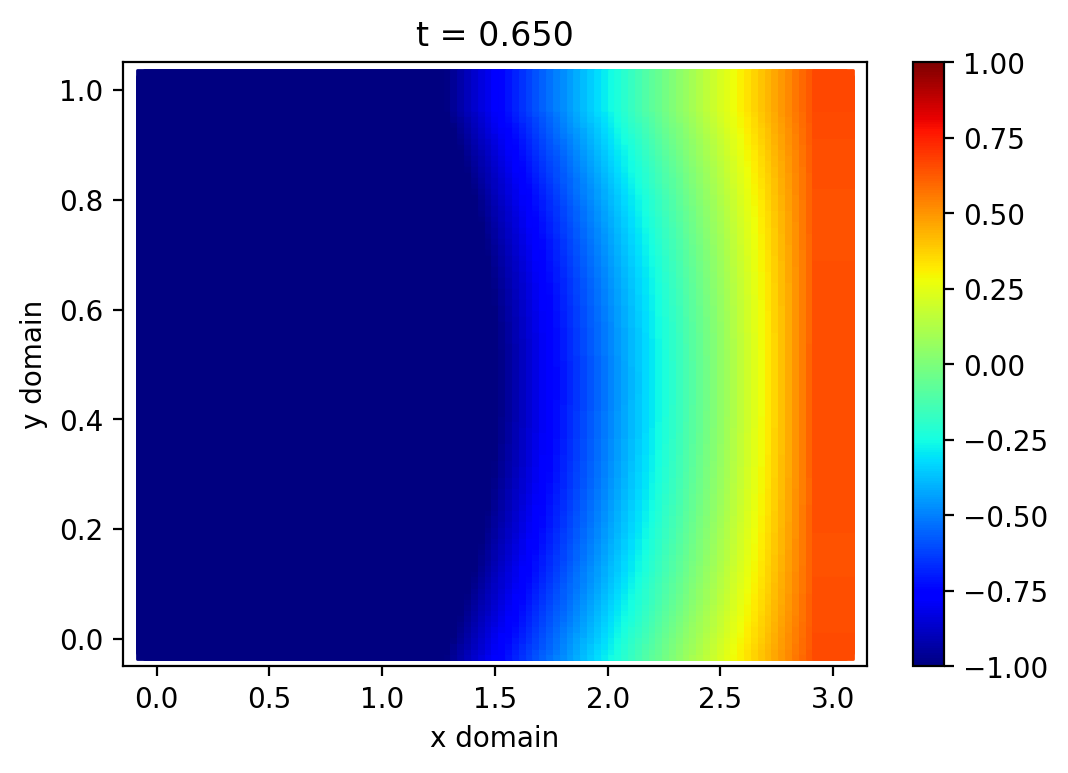

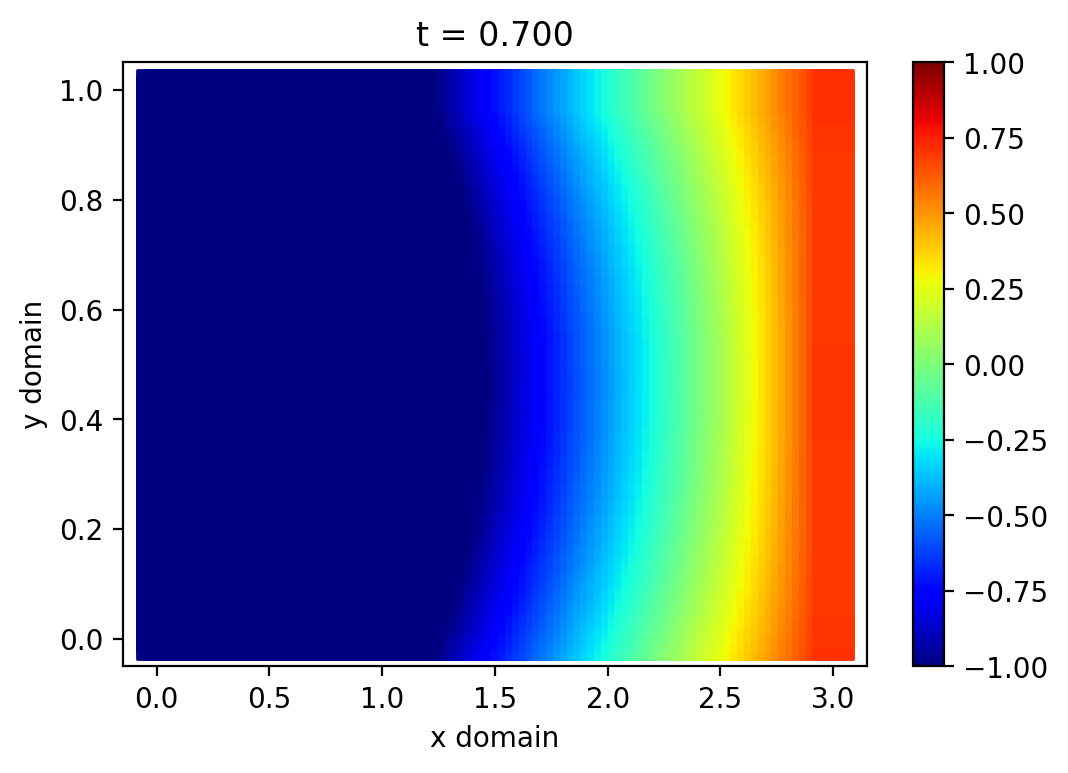

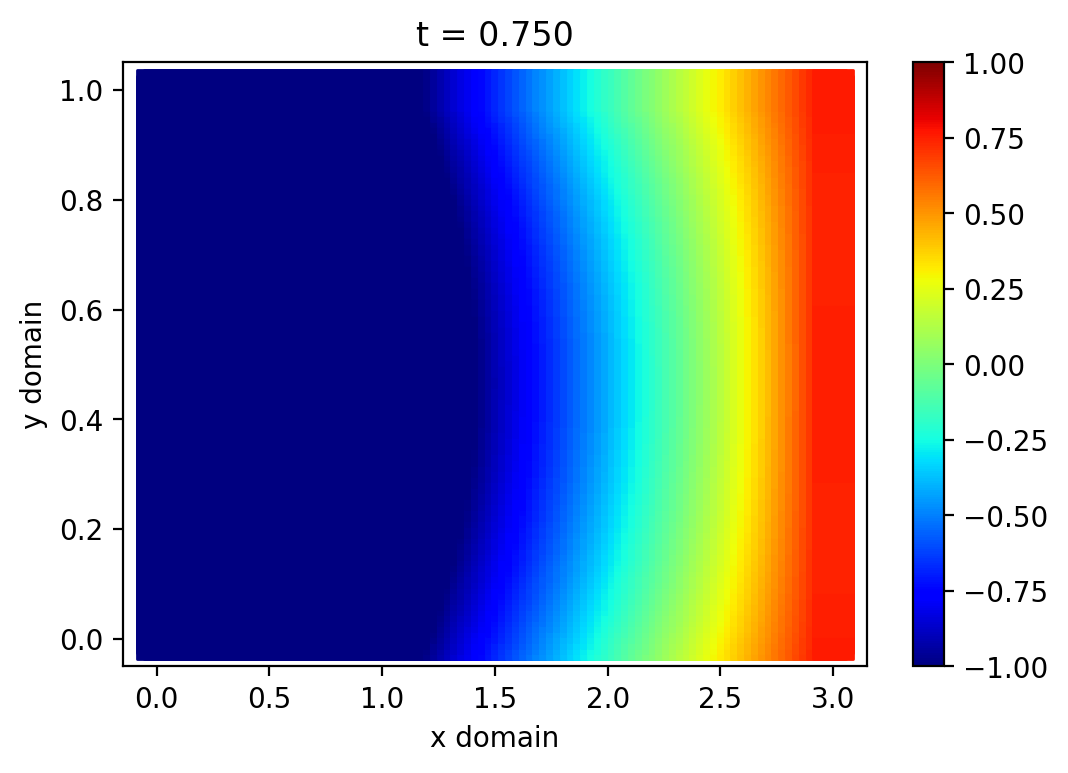

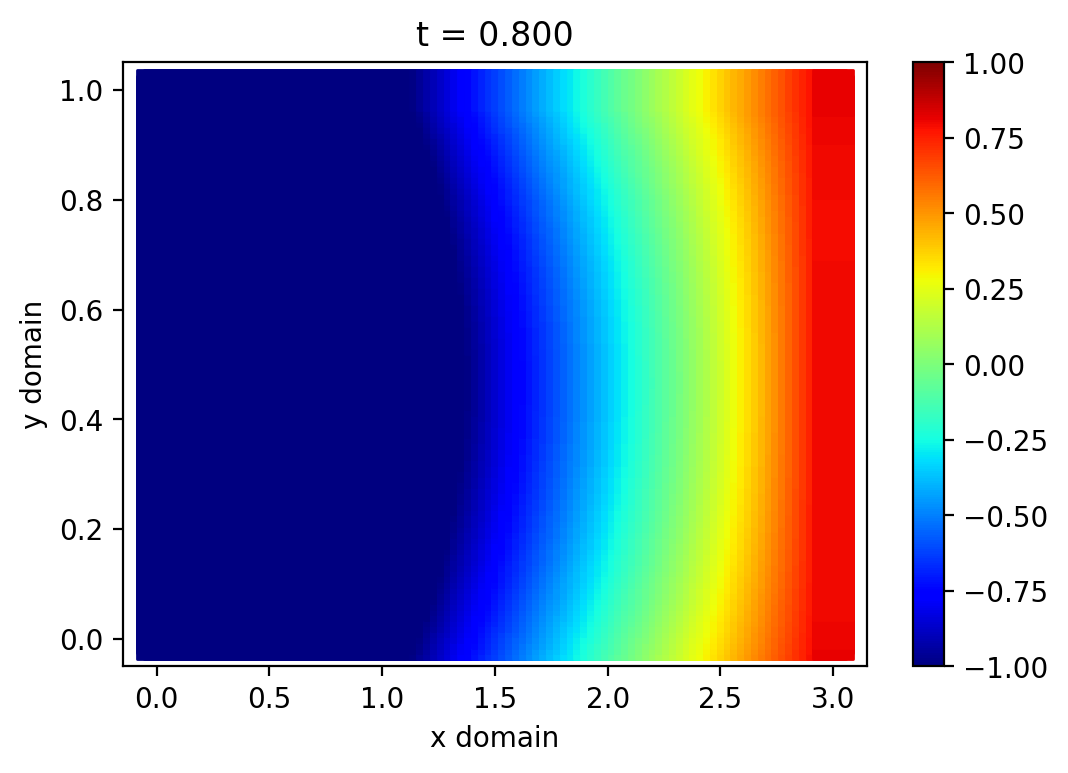

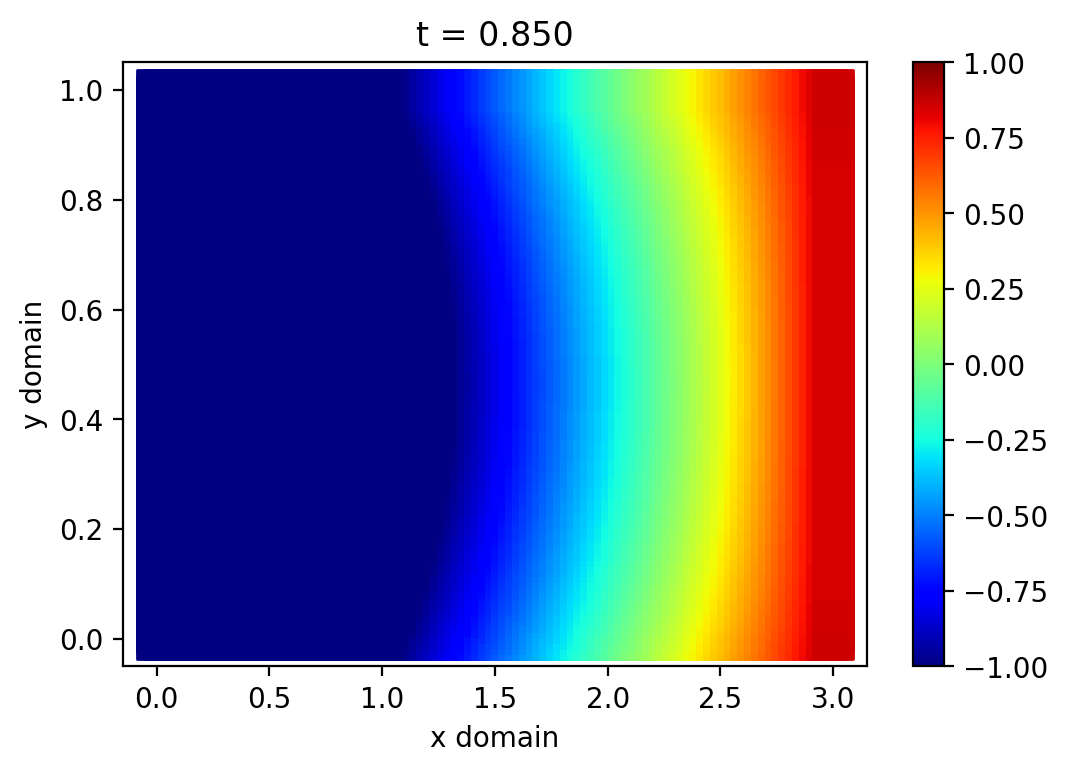

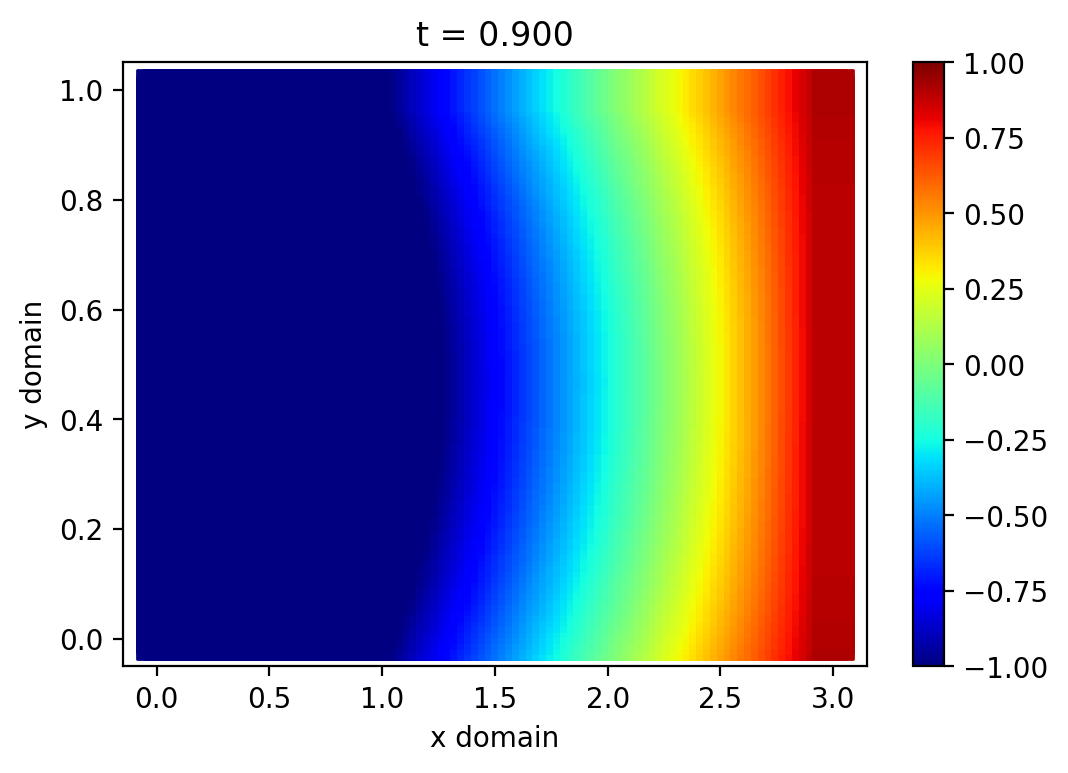

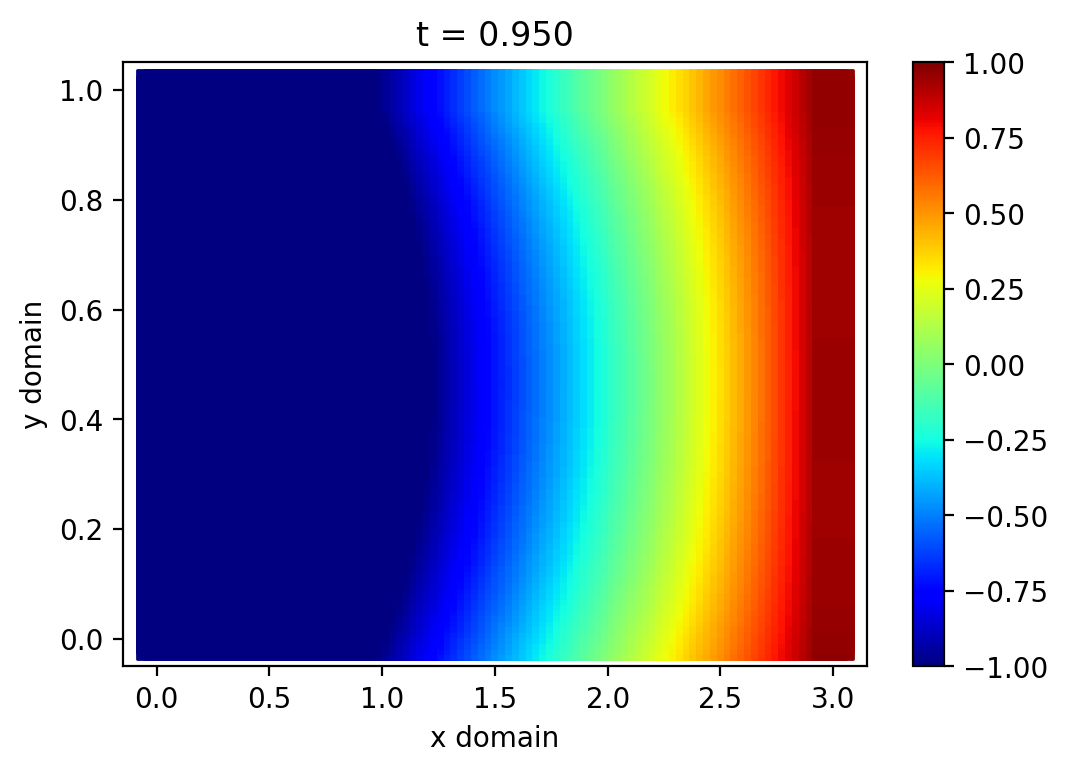

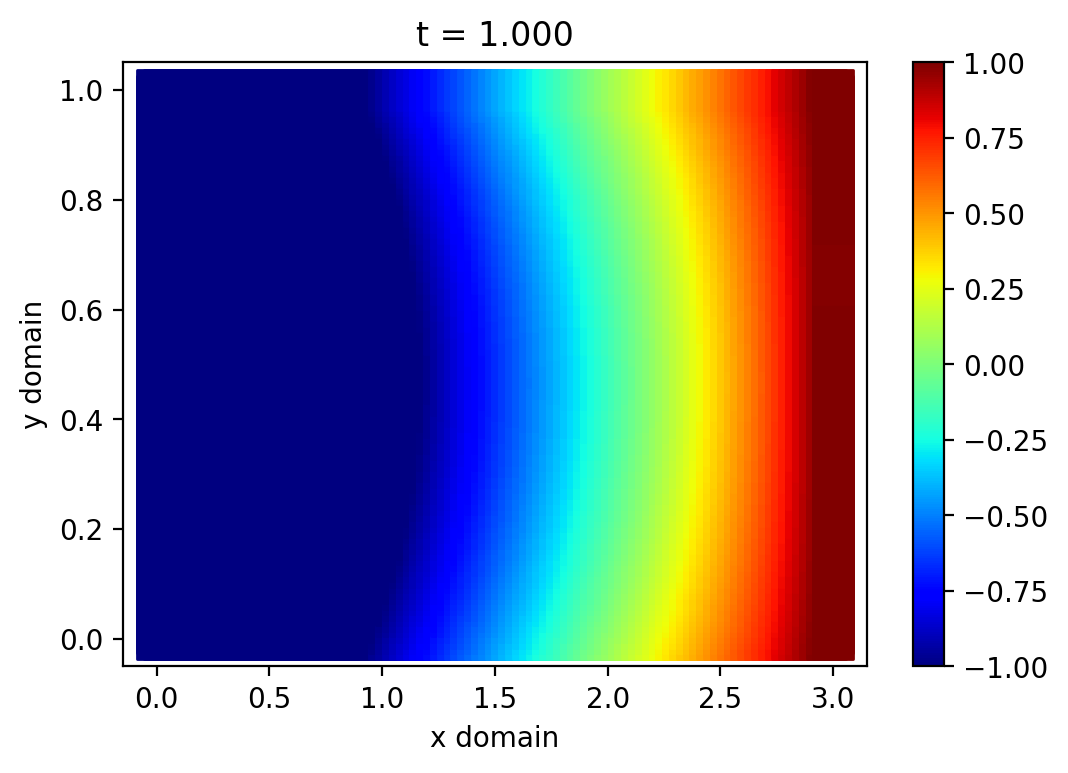

In [ ]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 1, 100)
t = np.linspace(0,1, 21)

test_x, test_t, test_y = np.meshgrid(x, t, y)
test_domain = np.vstack(    ( np.ravel(test_x), np.ravel(test_y), np.ravel(test_t) )    ).T
prediction = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)

save_directory = './results'
plot_mean_data_history(1, (100,100,21), np.abs(residual),'residual',save_directory)
plot(test_domain,(100,100,21), prediction, save_directory,'prediction')


